In [1]:
import sys
sys.path.insert(0, '../../../')

import pandas as pd
from preprocess import Audio_Processor
from sklearn import metrics
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
import numpy as np
from data_utils import enumerate_strings
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 16000
blocksize = int(SR/2)
overlap = int(SR/4)

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
path_to_db = '../../../../../data/FSDKaggle2018/'
dataset = pd.read_csv(path_to_db + 'meta/train.csv')
dataset = dataset.drop(['manually_verified', 'freesound_id', 'license'], axis=1)
ps = Audio_Processor(path_to_db + 'train/')
classes = dataset.label.unique()
h_classes = ['Human & Animal', 'Interacting Materials', 'Musical Instruments']
mapping = {'Hi-hat': h_classes[2],
           'Saxophone': h_classes[2],
           'Trumpet': h_classes[2],
           'Glockenspiel': h_classes[2],
           'Cello': h_classes[2],
           'Knock': h_classes[1],
           'Gunshot_or_gunfire': h_classes[1],
           'Clarinet': h_classes[2],
           'Computer_keyboard': h_classes[1],
           'Keys_jangling': h_classes[1],
           'Snare_drum': h_classes[2],
           'Writing': h_classes[1],
           'Laughter': h_classes[0],
           'Tearing': h_classes[1],
           'Fart': h_classes[1],
           'Oboe': h_classes[2],
           'Flute': h_classes[2],
           'Cough': h_classes[0],
           'Telephone': h_classes[1],
           'Bark': h_classes[0],
           'Chime': h_classes[2],
           'Bass_drum': h_classes[2],
           'Bus': h_classes[1],
           'Squeak': h_classes[0],
           'Scissors': h_classes[1],
           'Harmonica': h_classes[2],
           'Gong': h_classes[2],
           'Microwave_oven': h_classes[1],
           'Burping_or_eructation': h_classes[0],
           'Double_bass': h_classes[2],
           'Shatter': h_classes[1],
           'Fireworks': h_classes[1],
           'Tambourine': h_classes[2],
           'Cowbell': h_classes[2],
           'Electric_piano': h_classes[2],
           'Meow': h_classes[0],
           'Drawer_open_or_close': h_classes[1],
           'Applause': h_classes[1],
           'Acoustic_guitar': h_classes[2],
           'Violin_or_fiddle': h_classes[2],
           'Finger_snapping': h_classes[1]
           }
dataset['h_target'] = None
for index, row in dataset.iterrows():
    row['target'] = np.where(classes == row['label'])
    dataset.loc[index, 'h_target'] = mapping[row['label']]
dataset.columns = ['filename', 'target', 'h_target']
enum_map = enumerate_strings(dataset, ['filename'])

## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [5]:
df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        blocksize=blocksize, 
                        overlap=overlap,
                        folds=10,
                        random_state=42
                       )

In [6]:
df.describe()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
count,9473.000000,9473.000000,9473.000000,9473.000000,9473.000000,9473.000000,9473.000000,9473.000000,9473.000000,9473.000000,...,9473.000000,9473.000000,9473.000000,9473.000000,9473.000000,9473.000000,9473.000000,9473.000000,9473.000000,9473.000000
mean,63.840506,39.009271,30.841865,26.129657,23.141530,22.596056,22.159133,22.151773,21.959284,21.574367,...,-0.030764,-0.037914,16.811013,31.301487,39.870020,25.644474,5.142288,1.356804,20.385728,5.498892
std,24.804595,14.207352,11.682182,10.258962,10.060201,10.497362,10.686025,11.297858,11.418380,11.281570,...,0.133288,0.128908,145.991053,259.724493,3347.367827,14.466254,119.131957,0.731472,12.262045,2.872690
min,0.392575,0.489099,0.196515,0.156041,0.185966,0.205730,0.115668,0.130016,0.115219,0.068267,...,-0.730182,-0.657203,5.133794,9.052695,1.475783,7.512562,0.538489,0.000000,0.000000,1.000000
25%,46.650211,29.533018,22.844659,18.828809,15.464836,14.336588,13.648937,12.999737,12.679578,12.184562,...,-0.102760,-0.106726,10.896517,21.042212,3.699491,17.981131,2.296572,1.000000,10.000000,3.000000
50%,61.129505,37.712981,29.250918,24.578007,21.373277,20.426717,19.909389,19.524411,19.204019,18.940563,...,-0.024256,-0.028630,13.815379,25.831096,4.811992,22.536299,3.441672,2.000000,20.000000,5.000000
75%,78.921797,47.228478,36.981678,32.222576,29.481046,29.527110,29.527992,29.901918,29.990971,29.622557,...,0.039586,0.033423,17.247248,32.163839,6.056353,28.917977,5.036633,2.000000,32.000000,8.000000
max,179.244550,117.985305,100.398747,84.425956,69.668282,80.165987,80.375489,83.322255,107.694805,78.730016,...,0.639907,0.652953,14182.173175,25252.005169,325802.043087,407.859773,11597.025918,2.000000,40.000000,10.000000


In [7]:
from sklearn.model_selection import train_test_split
train, test, = train_test_split(
                        df[df.fold != 1], test_size=0.20, random_state=42)

In [8]:
train_X = train.drop(['target', 'h_target', 'fold'], axis=1)
train_y = train['h_target']
test_X = test.drop(['target', 'h_target', 'fold'], axis=1)
test_y = test['h_target']

# Training

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_X)
feat_red = PCA(n_components=30)
feat_red.fit(train_X,y=train_y)
train_X = feat_red.transform(train_X)

params = {
          'n_neighbors': range(5,25,1),
          'algorithm': ('ball_tree', 'kd_tree', 'brute')
         }

knn = KNN(n_neighbors=15, algorithm='ball_tree')

clf = GridSearchCV(knn, params, cv=5)

clf.fit(train_X, train_y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=15, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': range(5, 25), 'algorithm': ('ball_tree', 'kd_tree', 'brute')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [10]:
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_algorithm',
 'param_n_neighbors',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'split2_test_score',
 'split2_train_score',
 'split3_test_score',
 'split3_train_score',
 'split4_test_score',
 'split4_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

0.6668621700879765
Confusion matrix, without normalization
[[ 88 124  41]
 [ 66 432  87]
 [ 58 192 617]]


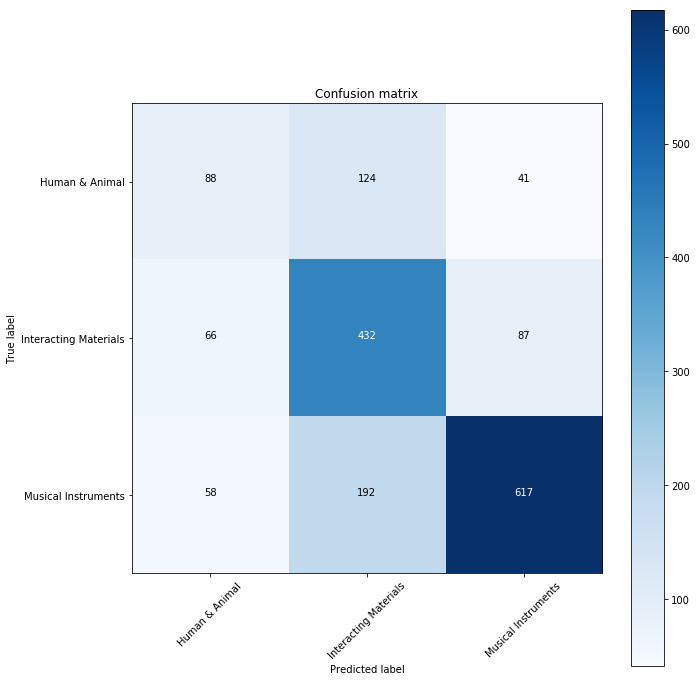

In [11]:
test_X = scaler.transform(test_X)
test_X = feat_red.transform(test_X)
pred = clf.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

# All Data

In [12]:
all_df = df[df.fold == 1]

In [13]:
all_df.head()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
3,42.012516,22.479535,22.556516,17.965780,19.553046,29.063427,21.927783,16.140392,21.548869,18.049557,...,-0.502283,-0.275542,17.208382,40.256547,5.833167,30.462545,3.364590,2,19,1
10,37.675353,41.446954,23.932229,30.136502,23.834413,30.583590,33.244240,39.866294,37.333223,27.274805,...,-0.024136,0.000510,15.435933,35.598391,2.768260,25.166738,2.892482,2,23,1
14,54.936468,31.764979,23.867434,18.535742,16.448322,15.815429,15.674325,15.248308,16.365607,16.346473,...,0.141709,0.119117,10.716867,24.684437,5.651404,23.451511,5.032840,2,6,1
19,101.631567,49.933356,34.796623,23.512867,20.040428,16.778372,15.272026,14.935118,12.909392,13.788147,...,-0.028058,-0.011733,15.401430,18.736672,4.030747,19.464776,4.972638,0,26,1
29,77.982493,53.665062,41.044582,39.212192,41.684710,41.724422,34.838319,37.285043,33.080185,39.280359,...,0.046511,-0.068727,12.214481,21.549435,4.444077,19.453103,5.637026,2,7,1


In [14]:
X = all_df.drop(['target', 'h_target', 'fold'], axis=1)
y = all_df['h_target']
X = scaler.transform(X)
X = feat_red.transform(X)

0.6729957805907173
Confusion matrix, without normalization
[[ 51  61  23]
 [ 37 248  51]
 [ 26 112 339]]


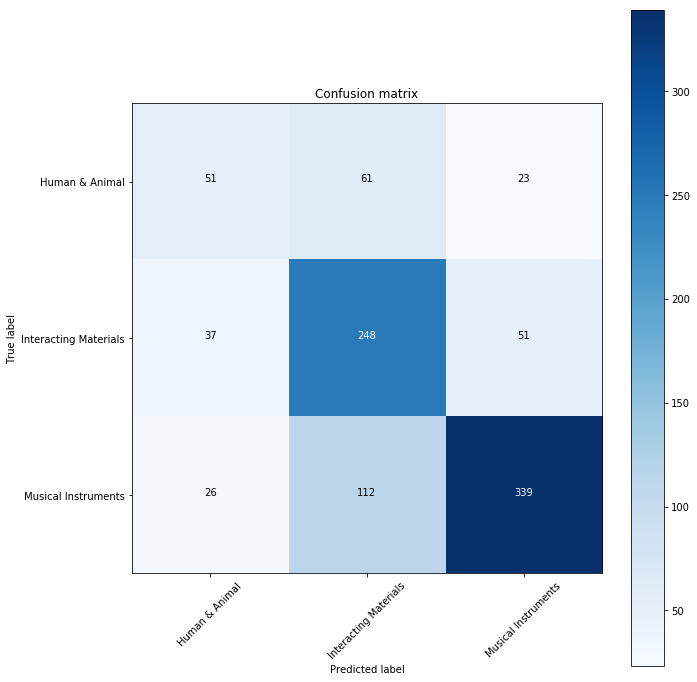

In [15]:
pred = clf.predict(X)
pred_prob = clf.predict_proba(X)
print(metrics.accuracy_score(y, pred))
cm = metrics.confusion_matrix(y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

In [16]:
clf.best_estimator_ 

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=9, p=2,
           weights='uniform')

In [17]:
import seaborn as sns
misclassified = {
    'Actual h_target': [],
    'Actual target': [],
    'Anim_prob': [],
    'Interact_prob': [],
    'Music_prob': []
}
for row, p, prob, Y in zip(all_df.iterrows(), pred, pred_prob, y):
    Y = int(Y)
    p = int(p)
    if p!=Y:
        misclassified['Actual target'].append(classes[int(row[1]['target'])])
        misclassified['Actual h_target'].append(h_classes[p])
        misclassified['Anim_prob'].append(prob[0])
        misclassified['Interact_prob'].append(prob[1])
        misclassified['Music_prob'].append(prob[2])

misclassified = pd.DataFrame.from_dict(misclassified)
misclassified.head()

,Actual h_target,Actual target,Anim_prob,Interact_prob,Music_prob
0,Human & Animal,Gunshot_or_gunfire,0.444444,0.333333,0.222222
1,Interacting Materials,Clarinet,0.000000,0.777778,0.222222
2,Interacting Materials,Squeak,0.000000,1.000000,0.000000
3,Musical Instruments,Harmonica,0.222222,0.222222,0.555556
4,Musical Instruments,Burping_or_eructation,0.000000,0.444444,0.555556


In [18]:
average_prob = misclassified.groupby('Actual h_target').mean()
average_prob.head()

,Anim_prob,Interact_prob,Music_prob
Actual h_target,,,
Human & Animal,0.520282,0.285714,0.194004
Interacting Materials,0.166346,0.632627,0.201028
Musical Instruments,0.124625,0.231231,0.644144


In [19]:
average_prob = misclassified.groupby('Actual target').mean()
average_prob

,Anim_prob,Interact_prob,Music_prob
Actual target,,,
Acoustic_guitar,0.290598,0.598291,0.111111
Applause,0.151515,0.202020,0.646465
Bass_drum,0.125000,0.250000,0.625000
Burping_or_eructation,0.177778,0.288889,0.533333
Bus,0.155556,0.666667,0.177778
Cello,0.216049,0.561728,0.222222
Chime,0.191919,0.636364,0.171717
Clarinet,0.174603,0.619048,0.206349
Computer_keyboard,0.555556,0.111111,0.333333


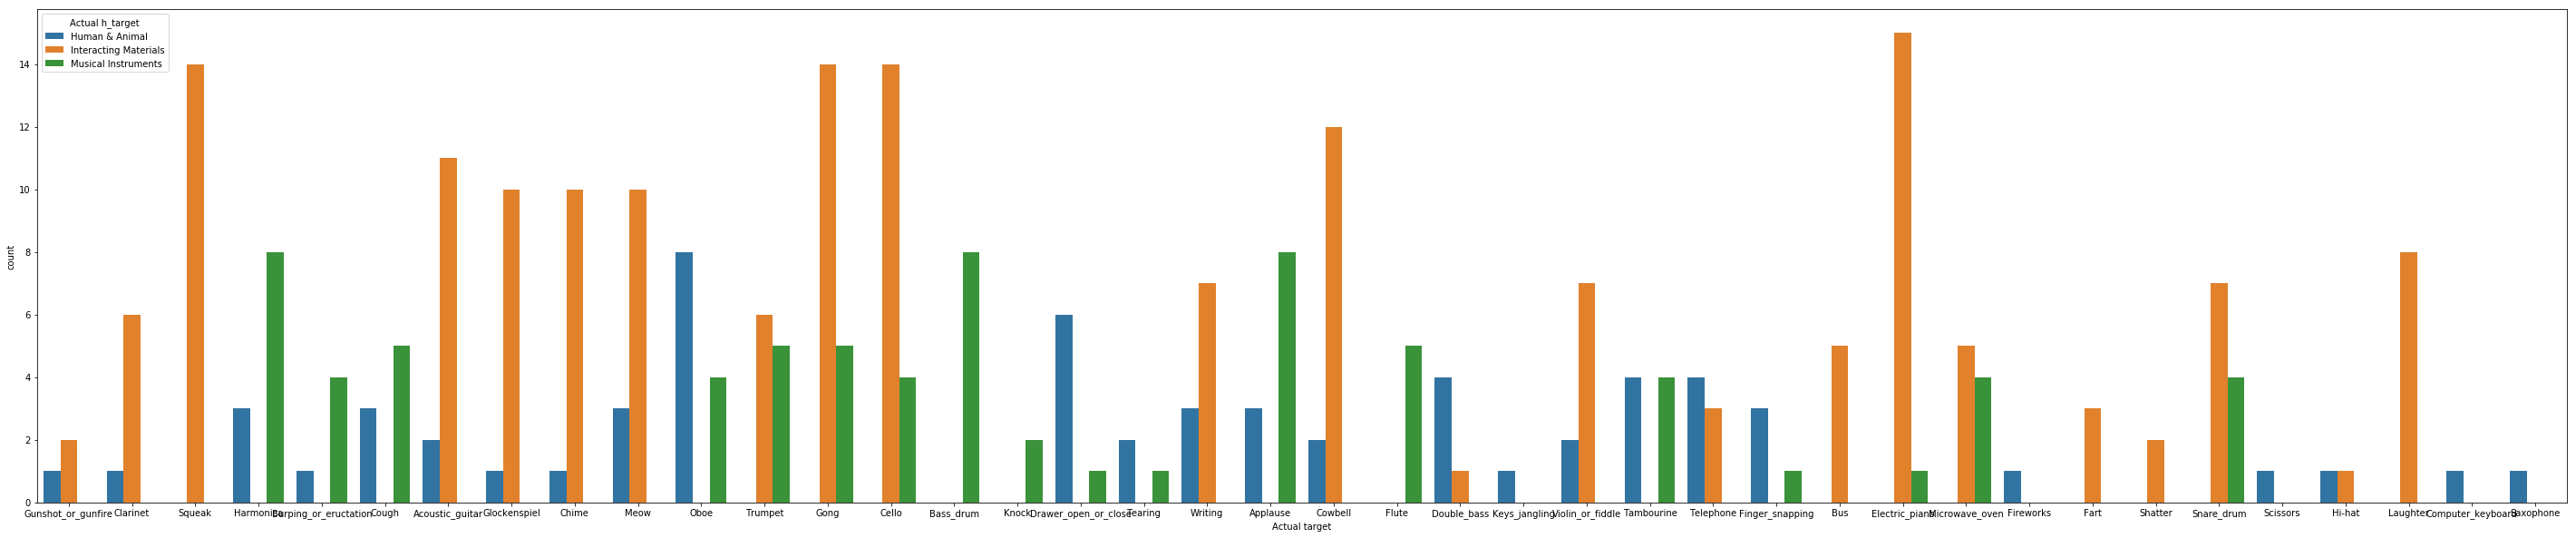

In [20]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(50,10))
sns.countplot(x='Actual target', hue='Actual h_target',data=misclassified)